# 개, 고양이 분류(partial) - CNN v2
- 부분 데이터:

    훈련_ 개: 1000, 고양이: 1000; 테스트_ 개: 500, 고양이: 500
- 이미지 센터링 처리

In [1]:
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

--2022-05-24 06:34:46--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 74.125.68.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip.1’

cats_and_dogs_filte 100%[===================>]  65.43M   215MB/s    in 0.3s    

2022-05-24 06:34:47 (215 MB/s) - ‘cats_and_dogs_filtered.zip.1’ saved [68606236/68606236]



In [2]:
!unzip cats_and_dogs_filtered.zip > /dev/null

replace cats_and_dogs_filtered/vectorize.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
seed = 2022
np.random.seed(seed)
tf.random.set_seed(seed)

- 데이터 탐색

In [4]:
# 이미지를 축소/확대 및 센터링해서 이미지를 반환하는 함수
IMAGE_SIZE = 150

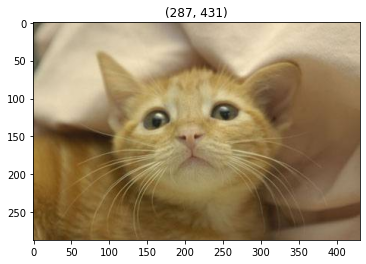

In [5]:
import cv2
fname = 'cats_and_dogs_filtered/train/cats/cat.475.jpg'
img = cv2.imread(fname)[:,:,::-1]
plt.imshow(img), plt.title(img.shape[:-1]);

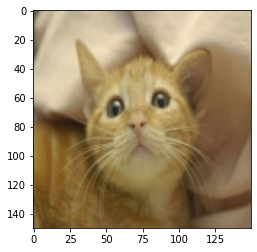

In [6]:
plt.imshow(cv2.resize(img, dsize=(150,150), interpolation=cv2.INTER_AREA))

In [7]:
h, w, _ = img.shape
h, w

(287, 431)

In [8]:
if h > w:
    width, height = IMAGE_SIZE, (h * IMAGE_SIZE) // w
else:
    width, height = (w * IMAGE_SIZE) // h, IMAGE_SIZE

In [9]:
# Pillow image: new_img = np.array(img.resize((width, height)))
new_img = cv2.resize(img, dsize=(width,height), interpolation=cv2.INTER_AREA)
new_img.shape

(150, 225, 3)

In [10]:
diff = abs(width - height) //2

In [11]:
if h > w:
    final_img = new_img[diff:diff+IMAGE_SIZE, :]
else:
    final_img = new_img[:,diff:diff+IMAGE_SIZE]

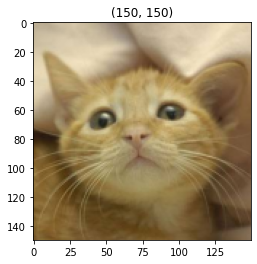

In [12]:
plt.imshow(final_img), plt.title(final_img.shape[:-1]);

In [13]:
from PIL import Image
def center_img(img, src_format='OpenCV', dst_format='OpenCV'):
    '''
    IMAGE_SIZE = 150
    '''
    if src_format == 'OpenCV':
        h, w = img.shape[:-1]
    else:                       # Pillow
        h, w = np.array(img).shape[:-1]
    
    if h > w:
        width, height = IMAGE_SIZE, (h * IMAGE_SIZE) // w
    else:
        width, height = (w * IMAGE_SIZE) // h, IMAGE_SIZE
    
    interpolation = cv2.INTER_AREA if w + h > 300 else cv2.INTER_CUBIC
    new_img = cv2.resize(img, dsize=(width,height), interpolation=interpolation)
    
    diff = abs(width - height) //2
    if h > w:
        final_img = new_img[diff:diff+IMAGE_SIZE, :]
    else:
        final_img = new_img[:,diff:diff+IMAGE_SIZE]
    
    return final_img if dst_format == 'OpenCV' else Image.fromarray(final_img)

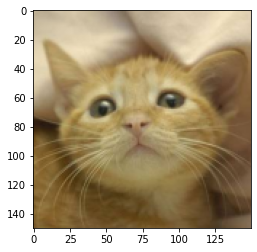

In [14]:
img = cv2.imread(fname)[:,:,::-1]
plt.imshow(center_img(img));

- 파일 읽어서 센터 이미지로 변환해서 저장

In [15]:
CENTER_DIR = 'cats_and_dogs_centered'
train_dir = f'{CENTER_DIR}/train'
validation_dir = f'{CENTER_DIR}/validation'
train_cats_dir = f'{CENTER_DIR}/train/cats'
train_dogs_dir = f'{CENTER_DIR}/train/dogs'
validation_cats_dir = f'{CENTER_DIR}/validation/cats'
validation_dogs_dir = f'{CENTER_DIR}/validation/dogs'

In [16]:
import os
if not os.path.exists(CENTER_DIR):
    os.mkdir(CENTER_DIR)
for dir in [train_dir,validation_dir,train_cats_dir,train_dogs_dir,validation_cats_dir,validation_dogs_dir]:
    os.mkdir(dir)

FileExistsError: ignored

In [ ]:
old_train_cats_dir = 'cats_and_dogs_filtered/train/cats'
old_train_dogs_dir = 'cats_and_dogs_filtered/train/dogs'
old_validation_cats_dir = 'cats_and_dogs_filtered/validation/cats'
old_validation_dogs_dir = 'cats_and_dogs_filtered/validation/dogs'

In [ ]:
# cats_and_dogs_filtered -> image 축소/확대 후 centering -> cats_and_dogs_centered
from glob import glob

for src_dir in [old_train_cats_dir, old_train_dogs_dir, old_validation_cats_dir, old_validation_dogs_dir]:
    # dst_dir = src_dir.split('/')[1:]
    # dst_dir = '/'.join([CENTER_DIR] + dst_dir)
    dst_dir = src_dir.replace('filtered', 'centered')
    for fname in glob(f'{src_dir}/*.jpg'):
        dst_fname = fname.split('/')[-1]
        # src_img = Image.open(fname)
        src_img = cv2.imread(fname)[:,:,::-1]
        dst_img = center_img(src_img, src_format='OpenCV', dst_format='OpenCV')       # Pillow or OpenCV
        dst_img.save(f'{dst_dir}/{dst_fname}')

In [ ]:
plt.figure(figsize=(12,6))
for i in range(4):
    plt.subplot(2, 4, i+1)
    cat = cv2.imread(os.path.join(train_cats_dir, train_cats_fnames[i]))[:,:,::-1]
    plt.imshow(cat), plt.axis('off'), plt.title(cat.shape[:-1])

    plt.subplot(2, 4, i+5)
    dog = cv2.imread(os.path.join(train_dogs_dir, train_dogs_fnames[i]))[:,:,::-1]
    plt.imshow(dog), plt.axis('off'), plt.title(dog.shape[:-1])
plt.show()

- 모델 구성

In [ ]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
model = Sequential([
    Conv2D(16, (3,3), input_shape=(150,150,3), activation='relu'),
    MaxPooling2D(),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.summary()

In [ ]:
from tensorflow.keras.optimizers import RMSprop
model.compile(
    optimizer=RMSprop(learning_rate=0.001, decay=1e-8),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
model_path = 'best-cats-and-dogs-v2.h5'
mc = ModelCheckpoint(model_path, save_best_only=True, verbose=1)
es = EarlyStopping(patience=10)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir, batch_size=20, class_mode='binary', target_size=(150,150)
)
test_generator = test_datagen.flow_from_directory(
    validation_dir, batch_size=20, class_mode='binary', target_size=(150,150)
)

In [ ]:
hist = model.fit(
    train_generator, 
    validation_data = test_generator,
    epochs=100, 
    steps_per_epoch=100, 
    validation_steps = 50,
    callbacks = [mc,es]
    )